## Analysis of stock prices using Principal Component Analysis 

In notebook1, you computed for each stock a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at time $t$ and $d(t)$ is the price diff or the price ratio. In this notebook, your task is to perform PCA on the `Diffs` sequences for all the stocks

In this notebook you will read the file `SP500.csv` that you prepared in notebook 1 into a `Spark` dataframe and then use the code in `lib/spark_PCA.py` to perform PCA on the diff sequences.

We start by starting a spark Context and reading the file into a dataframe.

### Create a Spark context and import dependencies

In [1]:
import pyspark
from pyspark import SparkContext

sc = SparkContext(master="local",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov

Populating the interactive namespace from numpy and matplotlib


### Read data

Read the file `SP500.csv` into a `Spark` dataframe. The file contains `_D` (diff) and `_P` (stock price) values for all tickers, for all the `13422` dates for which we have stock measurements.

In [2]:
# read the file in a dataframe.
df=sqlContext.read.csv('data/SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_D' in c]

### Partition Columns

Complete the function `partition_columns` to partition the columns of the dataframe `df` into `train` and `test`  set, each of them sorted lexicographically. 

Input: `df` dataframe read in 1.2

Returns: `tickers` - list of tickers 

Example Output:

   ['train/AAPL_D',
 'train/ABC_D',
 'train/ABT_D',
 'train/ACN_D',
 'train/ADBE_D',]
  
Steps:
1. Obtain the column names of the given dataframe using `df.columns`
2. For each column name with a `_D` suffix, store the ticker name
3. Maintain two lists for ticker names - one for training examples and one for test examples
3. For each ticker name extracted, check if the ticker is a `train` example. If so, append it to the list of training examples. If not, append it to the test list
4. Sort the training and test lists

In [4]:
def partition_columns(df):
    train_col= set()
    test_col= set()
    
    for name in df.columns:
        if name.endswith('_D'):
            
            if name.startswith('train'):
                train_col.add(name)

            elif name.startswith('test'):
                test_col.add(name)
            
    train_col = sorted(list(train_col))
    test_col = sorted(list(test_col))
    
    return  train_col+test_col

In [5]:
columns = partition_columns(df)
df=df.select(columns)

In [6]:
assert type(columns) == list, 'Incorrect return type'
assert len(columns) == 481, 'Incorrect return value'
assert columns[10] == 'train/AEP_D'
assert columns[200] == 'train/KMB_D'

In [7]:
# HIDDEN TESTS

### Create an RDD of numpy arrays
In order to use `spark_PCA.py` we need to transform the dataframe into an RDD of numpy vectors.

#### Function `make_array`
Complete the function `make_array(row)` that takes as input a row of `df` and returns a numpy array (`dtype=np.float64`) that contains the values of the diff rolumns (`_D`). Use `np.nan_to_num` to transform `nan`s into zeros.

Input: Row of `df`

Output: numpy array of diff columns

In [8]:
def make_array(row):
    array = [x for x in row]
    array = np.asarray(array, dtype=np.float64)
    array = np.nan_to_num(array)
    return array

#### Create RDD

Use `map` to create an RDD called `Rows` of numpy arrays.

In [9]:
Rows= df.select(col).rdd.map(make_array) ### SOLUTION

In [10]:
# HIDDEN TESTS

### Compute covariance matrix

Here, we compute the covariance matrix of the data using `computeCov` in `spark_PCA.py`. The covariance matrix is of dimension `481 x 481`

In [11]:
OUT=computeCov(Rows)
OUT.keys()

dict_keys(['NO', 'E', 'Cov', 'Mean', 'O', 'NE', 'Var'])

### Compute eigenvalues and eigenvectors

Complete the function `compute_eig` to compute the eigenvalues and eigenvectors of the given covariance matrix. You may make use of the `eigh` function from the `numpy.linalg` library to do the same.

Input: 

cov - covariance matrix

Output: 

eigenval - eigenvalues in descending order
        
eigenvectors - In the same order as their corresponding eigenvalues
        
You need to reverse the order of the eigenvalues and eigenvectors returned by the `eigh` function since they are returned in ascending order

In [12]:
from numpy import linalg as LA
def compute_eig(cov):
    
    eigval, eigvec = LA.eigh(cov)
    
    eigval = eigval[::-1]
    eigvec = np.flip(eigvec, axis=1)
    
    return eigval, eigvec

In [13]:
eigval, eigvec = compute_eig(OUT['Cov'])

### Function `compute_PCA`

Complete the function `compute_PCA` that takes as input a list of tickers and computes the eigenvalues and eigenvectors.

Input: `tickers` - list of tickers

Output: `eigval`, `eigvec` - numpy arrays of eigenvalues and eigenvectors

Steps:
1. Given a list of tickers, create an RDD of numpy arrays using the `make_array` function similar to `1.4.2`
2. Using the `computeCov` function, compute the covariance matrix of the given list of tickers, similar to `1.5`. The object returned by `computeCov` is a dictionary with the `cov` key containing the covariance matrix.
3. Using the `compute_eig` function, compute the eigenvalues and eigenvectors of the covariance matrix obtained in step2 and store them in `eigval` and `eigvec` respectively

In [14]:
def compute_PCA(tickers):
    Rows= df.select(tickers).rdd.map(make_array)
    OUT=computeCov(Rows)
    eigval, eigvec = compute_eig(OUT['Cov'])
    
    return eigval, eigvec

In [15]:
columns=df.columns
col=[c for c in columns if '_D' in c]
eigval, eigvec = compute_PCA(col)

In [16]:
np.testing.assert_almost_equal(eigvec.dot(eigvec.T), eye(481), err_msg="Incorrect return value")
np.testing.assert_almost_equal(np.sort(eigval)[::-1], eigval, err_msg="Incorrect return value")

In [17]:
# HIDDEN TESTS

### Compute percentage-of-variance explained graph

In the cell below, write code to plot the percentage of variance explained as a function of the number of top eigen-vectors used.

You should get a figure similar to this:

![percent-var-explained](figs/percentageOfVarianceExplained.png)

Hint:
1. Use the eigenvalues computed in `1.6` to plot the explained variance

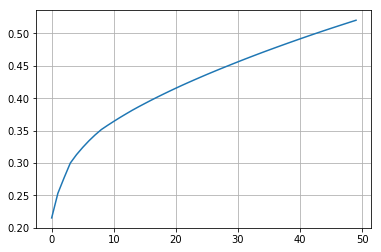

In [18]:
eigval_sum = np.sum(eigval)

percentage = []
tmp = 0.
for i in range(50):
    tmp += eigval[i]
    percentage.append(tmp/eigval_sum)
    
plt.plot(range(50), percentage)
plt.grid()

### Saving the information for the next stage

In [19]:
len(columns),eigvec.shape,eigval.shape
from pickle import dump
dump({'columns':columns,
     'eigvec':eigvec,
     'eigval':eigval},
    open('data/PCA.pickle','wb'))

### Checking your calculations
One good way to check your calculations is to create a scatter-plot projecting the data on two of the largest variance eigen-vectors.

In the directory `figs` you will find scatter plots corresponding to the six combinations of the top 4 eigenvectors.

In these scatter-plots the ticker is replaced by the sector ID.

Stocks from the same sector tend to have similar fluctuations. That is because they have similar sensitivities to costs (labor cost, energy) and profits (income distribution, holiday shopping). For example check out `figs/scatter.2.1.pdf` in which regions that are dominated by Finance, Energy or IT have been marked. 

In this section, you will create similar scatter plots and compare with those given. Your scatter-plots will be slightly different, because of the stocks you have eliminated, but spectral analysis is pretty robust, so your scatter plots should be quite similar (remember that the inverse of an eigen-vector is also an eigen-vector, so horizontal or vertical reflections of the scatter plot are meaningless).

#### Read data

Here, we read `Tickers.pkl` which is a dictionary with the keys: `Tickers` and `TickerInfo`. 

`Tickers` contains the ticker names and `TickerInfo` is a Pandas dataframe containing Company name, Sector and SectorID for each ticker

In [20]:
import pandas as pd
TickerInfo=pd.read_csv('data/tickerInfo.tsv',sep='\t')
TickerInfo.head()

,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


#### Map tickers to Sector IDs

Complete the function `map_sectorID` that takes as input `columns` containing ticker names that you extracted in 1.3 and returns a list `sectors` containing the sector ID for each ticker

Input: `columns` - list of ticker names

Example Input: ['train/RF_D', 'train/TIF_D', 'train/HAL_D']

Output: `sectors` - list of sector IDs, `known` - number of tickers with known category, `unknown` - number of tickers with unknown category

Example Output: ['FIN', 'CD', 'EN', 'CD', 'IT'], 200, 100

Steps:

1. In order to keep track of the number of tickers with known and unknown categories, intialise the counters `known` and `unknown` to 0
2. Use `.to_records()` on the Pandas dataframe TickerInfo[['Ticker','SECTOR_ID']] to create a dictionary mapping Ticker name to Sector ID
3. For each column name in `columns`, extract the ticker name by removing the `train` or `test` prefix and the `_D` suffix
3. For the extracted ticker name, check if the ticker is present in the dictionary created in 1
4. If yes, append the corresponding sectorID to `sectors` and increment the `known` counter
5. Else, append the ticker name to `sectors` and increment the `unknown` counter
6. Return `sectors`, `known` and `unknown`

In [22]:
def map_sectorID(columns):
    known = 0
    unknown = 0
    sectors = []
    
    tickerInfo = TickerInfo[['Ticker','SECTOR_ID']].to_records()
    record = {x[1]:x[2] for x in tickerInfo}
    
    for col in columns:
        if col.startswith('train'):
            name = col[col.index('train/')+6: col.index('_D')]
        elif col.startswith('test'):
            name = col[col.index('test/')+5: col.index('_D')]
        else:
            name = None
            
        if name in record.keys():
            known += 1
            sectors.append(record[name])
        elif name is not None:
            unknown += 1
            sectors.append(name)
    
    return sectors, known, unknown

In [23]:
sectors, known, unknown = map_sectorID(columns)

In [24]:
# HIDDEN TESTS

#### Generate Scatter plots

Complete the function `Scatter_Stocks` to generate a scatter plot of the stocks on the given pair of eigenvectors. The function takes as input the indices of the two eigenvectors and generates a scatter plot of the data projected on the pair of eigenvectors.

Input: i0, i1 - Eigenvector indices

Example Input: i0=0, i1=2 (eigenvectors 0 and 2 - eigvec[:, 0] and eigvec[:, 2])

Steps:
1. Using the `plt.subplots` function, set the figure size to (20, 20) in order that the stock ticker names are readable. Store the objects returned by `plt.subplots` in `fig` and `ax`
2. Set the X and Y axis limits to the minimum and maximum of the eigenvectors to be plotted on each axis using the `plt.xlim` and `plt.ylim` functions
3. Label the axes as follows: Coeff 0, Coeff 1, using `plt.xlabel` and `plt.ylabel`
4. for each ticker in `columns` that you generated in `1.3`, call the `ax.annotate` function in `matplotlib` using the `ax` object returned in `1` and annotate each point with the respective sectorID in `sectors`
5. The figure in `fig` is then saved according to the command given 

In [25]:
def Scatter_Stocks(i0=0,i1=1):
    
    P = np.stack((eigvec[:, i0], eigvec[:, i1]), axis=1)
    
    Rows= df.select(columns).rdd.map(make_array)
    OUT=computeCov(Rows)
    cov = OUT['Cov']
    
    data = cov.dot(P)
    
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(data[:, 0], data[:, 1])
    
    ax.set_xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    ax.set_ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    
    plt.xlabel = 'Coeff 0'
    plt.ylabel = 'Coeff 1'
    
#     ax.annotate

    for i, txt in enumerate(sectors):
        ax.annotate(txt, (data[i,0], data[i,1]))
    
    fig.savefig('figs/scatter.'+str(i0)+'.'+str(i1)+'.pdf', format='PDF');
    # After exporting, we clear the figure so that the plot does not appear in the notebook.
    fig.clear();
    return None

In [26]:
for i0 in range(4):
    for i1 in range(i0):
        print(i0,i1)
        Scatter_Stocks(i0,i1);

1 0
2 0
2 1
3 0
3 1
3 2


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

## Check 
Check that your `scatter.2.1.pdf` is similar to `scatter.2.1.annotated.pdf`. Note that the orientation of the eigen-vectors can be flipped.